In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/hotel-booking-demand/hotel_bookings.csv
/kaggle/input/rapids/rapids.0.12.0
/kaggle/input/rapids/rapids.0.11.0


Installing NVIDIA Rapids (CUDF & CUML) for rapid PCA and T-SNE analysis later.

In [2]:
import sys
!cp ../input/rapids/rapids.0.11.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

rapids/
rapids/bin/
rapids/bin/msgunfmt
rapids/bin/pyvenv
rapids/bin/msgen
rapids/bin/djpeg
rapids/bin/gdaltindex
rapids/bin/gss-client
rapids/bin/png-fix-itxt
rapids/bin/python3-config
rapids/bin/gif2rgb
rapids/bin/ncgen
rapids/bin/gdal-config
rapids/bin/PParse
rapids/bin/xzdec
rapids/bin/numba
rapids/bin/SAX2Count
rapids/bin/h5unjam
rapids/bin/glib-gettextize
rapids/bin/fc-list
rapids/bin/xzgrep
rapids/bin/giftool
rapids/bin/grpc_python_plugin
rapids/bin/k5srvutil
rapids/bin/gifbuild
rapids/bin/gflags_completions.sh
rapids/bin/uuclient
rapids/bin/gio-querymodules
rapids/bin/dask-ssh
rapids/bin/msguniq
rapids/bin/lz4c
rapids/bin/ncdump
rapids/bin/vacuumlo
rapids/bin/bzfgrep
rapids/bin/ngettext
rapids/bin/gdal_sieve.py
rapids/bin/gdalsrsinfo
rapids/bin/2to3-3.6
rapids/bin/lzdiff
rapids/bin/pg_receivewal
rapids/bin/rdjpgcom
rapids/bin/gnmanalyse
rapids/bin/pyvenv-3.6
rapids/bin/ktutil
rapids/bin/invproj
rapids/bin/pgbench
rapids/bin/protoc
rapids/bin/vacuumdb
rapids/bin/hdf24to8
rapids/

# 1. Introduction

In this project, I am going to build a model to predict whether the hotel will be booked or not.

# 2. Data Exploration

## 2.1 Plotting for association

In [3]:
import pandas as pd
df = pd.read_csv("../input/hotel-booking-demand/hotel_bookings.csv")

Looking at datasets.

In [4]:
df.head().transpose()

0             1             2  \
hotel                           Resort Hotel  Resort Hotel  Resort Hotel   
is_canceled                                0             0             0   
lead_time                                342           737             7   
arrival_date_year                       2015          2015          2015   
arrival_date_month                      July          July          July   
arrival_date_week_number                  27            27            27   
arrival_date_day_of_month                  1             1             1   
stays_in_weekend_nights                    0             0             0   
stays_in_week_nights                       0             0             1   
adults                                     2             2             1   
children                                   0             0             0   
babies                                     0             0             0   
meal                                      BB            BB            BB   
country                                  PRT           PRT           GBR   
market_segment                        Direct        Direct        Direct   
distribution_channel                  Direct        Direct        Direct   
is_repeated_guest                          0             0             0   
previous_cancellations                     0             0             0   
previous_bookings_not_canceled             0             0             0   
reserved_room_type                         C             C             A   
assigned_room_type                         C             C             C   
booking_changes                            3             4             0   
deposit_type                      No Deposit    No Deposit    No Deposit   
agent                                    NaN           NaN           NaN   
company                                  NaN           NaN           NaN   
days_in_waiting_list                       0             0             0   
customer_type                      Transient     Transient     Transient   
adr                                        0             0            75   
required_car_parking_spaces                0             0             0   
total_of_special_requests                  0             0             0   
reservation_status                 Check-Out     Check-Out     Check-Out   
reservation_status_date           2015-07-01    2015-07-01    2015-07-02   

                                           3             4  
hotel                           Resort Hotel  Resort Hotel  
is_canceled                                0             0  
lead_time                                 13            14  
arrival_date_year                       2015          2015  
arrival_date_month                      July          July  
arrival_date_week_number                  27            27  
arrival_date_day_of_month                  1             1  
stays_in_weekend_nights                    0             0  
stays_in_week_nights                       1             2  
adults                                     1             2  
children                                   0             0  
babies                                     0             0  
meal                                      BB            BB  
country                                  GBR           GBR  
market_segment                     Corporate     Online TA  
distribution_channel               Corporate         TA/TO  
is_repeated_guest                          0             0  
previous_cancellations                     0             0  
previous_bookings_not_canceled             0             0  
reserved_room_type                         A             A  
assigned_room_type                         A             A  
booking_changes                            0             0  
deposit_type                      No Deposit    No Deposit  
agent                                    304           240  
company  

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [6]:
df.describe().transpose()

count         mean         std      min  \
is_canceled                     119390.0     0.370416    0.482918     0.00   
lead_time                       119390.0   104.011416  106.863097     0.00   
arrival_date_year               119390.0  2016.156554    0.707476  2015.00   
arrival_date_week_number        119390.0    27.165173   13.605138     1.00   
arrival_date_day_of_month       119390.0    15.798241    8.780829     1.00   
stays_in_weekend_nights         119390.0     0.927599    0.998613     0.00   
stays_in_week_nights            119390.0     2.500302    1.908286     0.00   
adults                          119390.0     1.856403    0.579261     0.00   
children                        119386.0     0.103890    0.398561     0.00   
babies                          119390.0     0.007949    0.097436     0.00   
is_repeated_guest               119390.0     0.031912    0.175767     0.00   
previous_cancellations          119390.0     0.087118    0.844336     0.00   
previous_bookings_not_canceled  119390.0     0.137097    1.497437     0.00   
booking_changes                 119390.0     0.221124    0.652306     0.00   
agent                           103050.0    86.693382  110.774548     1.00   
company                           6797.0   189.266735  131.655015     6.00   
days_in_waiting_list            119390.0     2.321149   17.594721     0.00   
adr                             119390.0   101.831122   50.535790    -6.38   
required_car_parking_spaces     119390.0     0.062518    0.245291     0.00   
total_of_special_requests       119390.0     0.571363    0.792798     0.00   

                                    25%       50%     75%     max  
is_canceled                        0.00     0.000     1.0     1.0  
lead_time                         18.00    69.000   160.0   737.0  
arrival_date_year               2016.00  2016.000  2017.0  2017.0  
arrival_date_week_number          16.00    28.000    38.0    53.0  
arrival_date_day_of_month          8.00    16.000    23.0    31.0  
stays_in_weekend_nights            0.00     1.000     2.0    19.0  
stays_in_week_nights               1.00     2.000     3.0    50.0  
adults                             2.00     2.000     2.0    55.0  
children                           0.00     0.000     0.0    10.0  
babies                             0.00     0.000     0.0    10.0  
is_repeated_guest                  0.00     0.000     0.0     1.0  
previous_cancellations             0.00     0.000     0.0    26.0  
previous_bookings_not_canceled     0.00     0.000     0.0    72.0  
booking_changes                    0.00     0.000     0.0    21.0  
agent                              9.00    14.000   229.0   535.0  
company                           62.00   179.000   270.0   543.0  
days_in_waiting_list               0.00     0.000     0.0   391.0  
adr                               69.29    94.575   126.0  5400.0  
required_car_parking_spaces        0.00     0.000     0.0     8.0  
total_of_special_requests          0.00     0.000     1.0     5.0

We can see that some features have "119390" counts while other features such as "agent" or "company" have less counts, which indicates these features have null values.

Let's see how many hotels have been checked out based on a histogram.

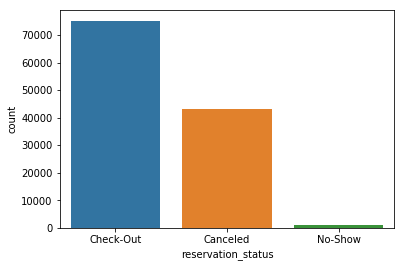

In [7]:
import seaborn as sns
sns.countplot(x='reservation_status',data=df)

Let's look at the distribution plot for two typees of stays (weekend and weekdays nights) just to see how they are distributed.

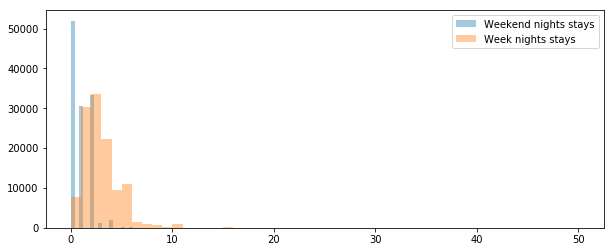

In [8]:
plt.figure(figsize=(10,4))
sns.distplot(df['stays_in_weekend_nights'],label="Weekend nights stays",axlabel=False, kde=False)
sns.distplot(df['stays_in_week_nights'],label="Week nights stays",axlabel=False, kde=False)
plt.legend()

Let's change the bin sizes and axis limits to show the plot better.

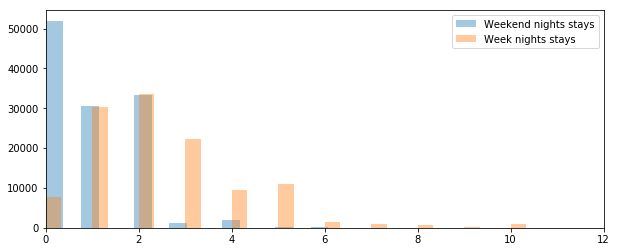

In [9]:
plt.figure(figsize=(10,4))
sns.distplot(df['stays_in_weekend_nights'],label="Weekend nights stays",axlabel=False, kde=False,bins=50)
sns.distplot(df['stays_in_week_nights'],label="Week nights stays",axlabel=False, kde=False,bins=150)
plt.xlim(0,12)
plt.legend()

Let's create box plots for each stay category (weekdays and weekends) showing the relationship between # of stay nights and reservation status

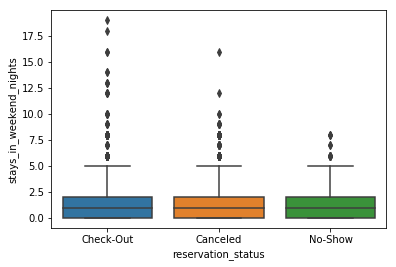

In [10]:
sns.boxplot(x='reservation_status',y='stays_in_weekend_nights',data=df)

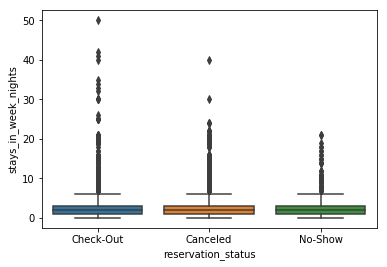

In [11]:
sns.boxplot(x='reservation_status',y='stays_in_week_nights',data=df)

Not a super clear relationship..

What about the relationship with "lead time"?

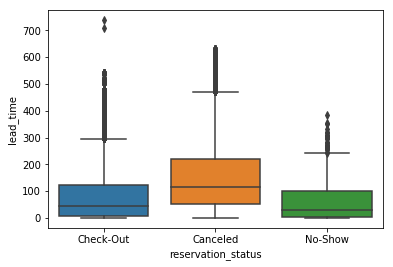

In [12]:
sns.boxplot(x='reservation_status',y='lead_time',data=df)

I can see that the canceled reservation had longer lead time than the checked out reservation.

Will there be any month effect? Let's see.

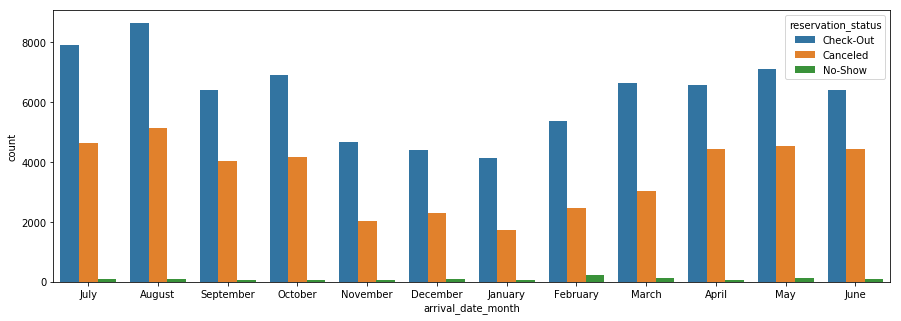

In [13]:
plt.figure(figsize=(15,5))
sns.countplot(x='arrival_date_month',data=df,hue='reservation_status')

Ah, interesting. It seems people canel less during the winter season (November - January). It could be due to the seasonal effect where (1) people generally travel less (so less cancelling) and (2) hotel prices go up so people do not want to pay additional fees when cancelling.

We can check the relationship between the number of guests and reservation status. For this, let's create a column that sums up the number of adults, children and babies in our dataframe.

In [14]:
df['total_guests']=df['adults']+df['children']+df['babies']

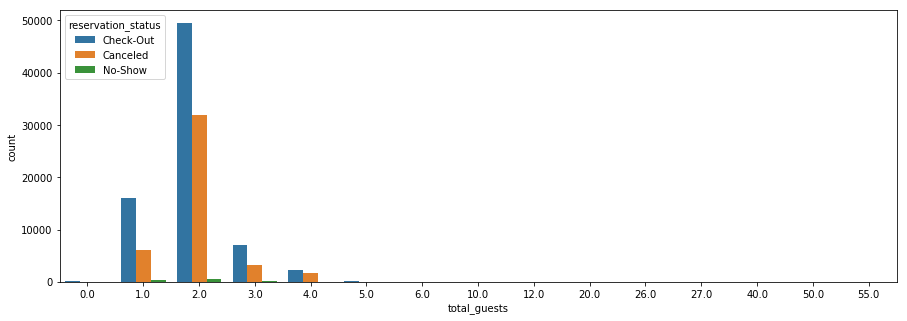

In [15]:
plt.figure(figsize=(15,5))
sns.countplot(x='total_guests',data=df,hue='reservation_status')

No linear correlation was found between the total # of guests and reservation status, but it seems like there was a very large number of guests that had booked a room, which makes sense because the "df.describe" table above shows that the max of adults was 55.

Let's look at this side by side for each category of guests (adults, children and babies)

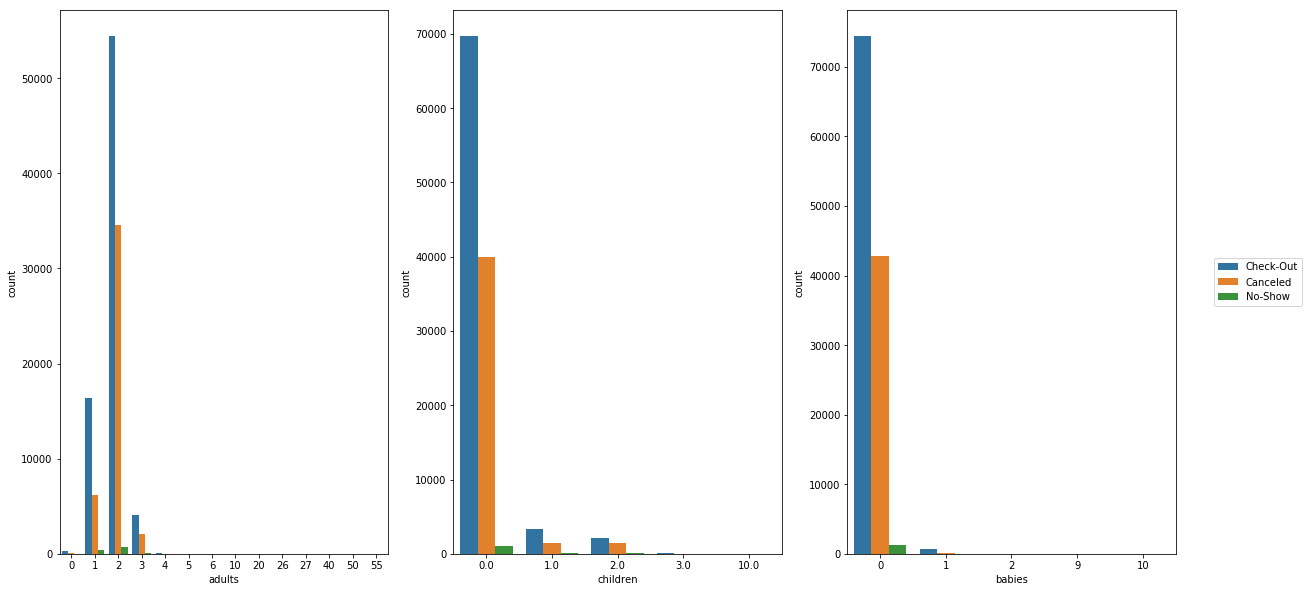

In [16]:
fig, ax =plt.subplots(nrows=1, ncols=3, figsize=(20,10))
g=sns.countplot(x='adults',data=df,hue='reservation_status',ax=ax[0])
g.legend_.remove()
g=sns.countplot(x='children',data=df,hue='reservation_status',ax=ax[1])
g.legend_.remove()
g=sns.countplot(x='babies',data=df,hue='reservation_status',ax=ax[2])
g.legend(loc='right', bbox_to_anchor=(1.4, 0.5), ncol=1)

fig.show()

## 2.2 Cramer's V for categorical features

Aside from the bruteforce way of checking each attribute looking at the plots as shown below, is there a mathematical way to select the parameters that are strongly correlated with each other? The issue here is that reservation_status are linked with some categorical attributes so we cannot simply use "df.corr()" to accurately get the correlation matrix.

There is Cramer's V model based on the chi squared satistic that can show how strongly nominal variables are associated with one another. This is very similar to correlation coefficient where 0 means no linear correlation and 1 means strong linear correlation.

I refered two posts on this : (1) https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9 (2) https://sonj.me/projects/2018/09/05/poisonous-mushroom-classification.html

I will first create a new dataframe that contains only categorical attributes. Up to this point, I used "reservation_status" to figure out whether the room has been booked or not. But actually I can use "is_cancelled" attribute which simply shows 0 for not canceled and 1 for canceled.

Let's drop "reservation_status" column from the original data frame, turn these 0 and 1 to categorical values (no and yes), and run Cramer's V analysis again.

In [17]:
df=df.drop('reservation_status',axis=1)

In [18]:
df['is_canceled']=df['is_canceled'].replace([0,1],["no","yes"])

In [19]:
#Extracting categorical feature columns
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols=list(set(cols) - set(num_cols))

In [20]:
df_cat=df[cat_cols]

In [21]:
df_cat.columns

Index(['reservation_status_date', 'market_segment', 'country', 'is_canceled',
       'deposit_type', 'customer_type', 'reserved_room_type',
       'assigned_room_type', 'distribution_channel', 'meal',
       'arrival_date_month', 'hotel'],
      dtype='object')

Creating functions to run Cramer's V analysis for categorical features

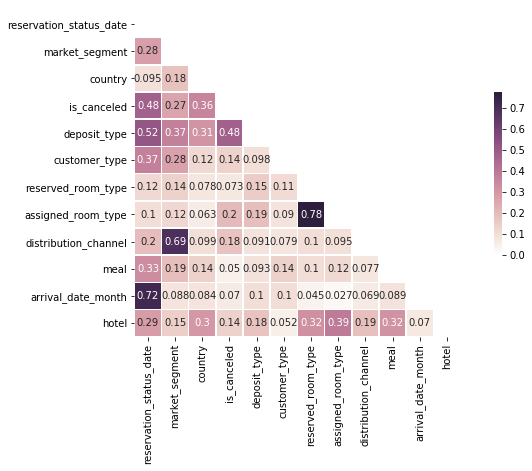

In [22]:
import itertools
import scipy

def cramers_corrected_stat(confusion_matrix):
    """
    Calculates the corrected Cramer's V statistic
    
    Args:
        confusion_matrix: The confusion matrix of the variables to calculate the statistic on
    
    Returns:
        The corrected Cramer's V statistic
    """
    
    #chi2, _, _, _ = scipy.stats.chi2_contingency(confusion_matrix)
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

#Getting the list of columns in the dataframe
cols = list(df_cat.columns.values)

#Creating an empty array to append to as we will go through iteratations to calculate correlations of every combination of variables.
emp_arr = np.zeros((len(cols),len(cols)))

#Iteraiting dataframe using itertools
#itertools.combinations() : Given an array of size n, generate and print all possible combinations of r elements in array.
for col1, col2 in itertools.combinations(cols, 2):
    A, B = df_cat[col1], df_cat[col2]
    idx1, idx2 = cols.index(col1), cols.index(col2)
    conf_mat = pd.crosstab(A,B) 
    #appending results to emp_array
    emp_arr[idx1, idx2] = cramers_corrected_stat(conf_mat.values)
    emp_arr[idx2, idx1] = emp_arr[idx1, idx2]

#creating a correlation matrix
corr = pd.DataFrame(emp_arr, index=cols, columns=cols)

# Mask to get lower triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

# Draw the heatmap with the mask 
fig = plt.figure(figsize=(12, 6))

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

Next, let's take a look at "deposit_type" attribute as it showed the highest correlation with the target variable. The reservation_status_date effect was already looked at in the previous section where we saw an intersting trend that people cancel less during the winter time.

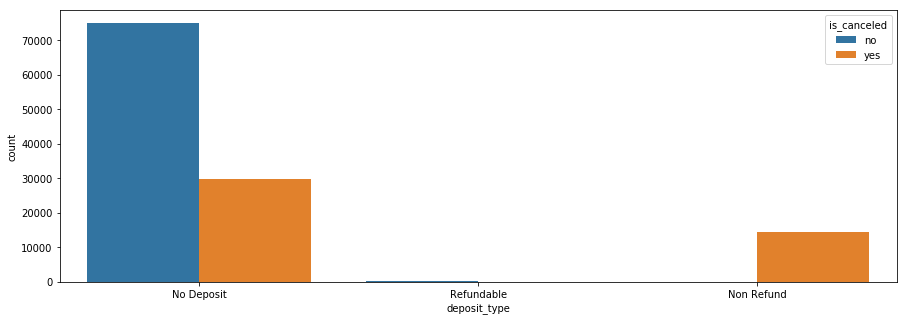

In [23]:
plt.figure(figsize=(15,5))
sns.countplot(x='deposit_type',data=df,hue='is_canceled')

Ah, we can see that with non-refundable deposits guests tend to cancel less than they would do with the no deposit cases.

## 2.3 Correlation for numerical features

Let's quickly glance at numerical features's correlations. Before that we need to re-convert "is_canceled" attribute to numerical values.

In [24]:
df['is_canceled']=df['is_canceled'].replace(["no","yes"],[0,1])

In [25]:
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  \
0                            0                          0   
1                            0                          0   
2                            0                          0   
3                            0                          0   
4                            0                          1   

   reservation_status_date total_guests  
0               2015-07-01          2.0  
1               2015-07-01          2.0  
2               2015-07-02          1.0  
3               2015-07-02          1.0  
4               2015-07-03          2.0  

[5 rows x 32 columns]

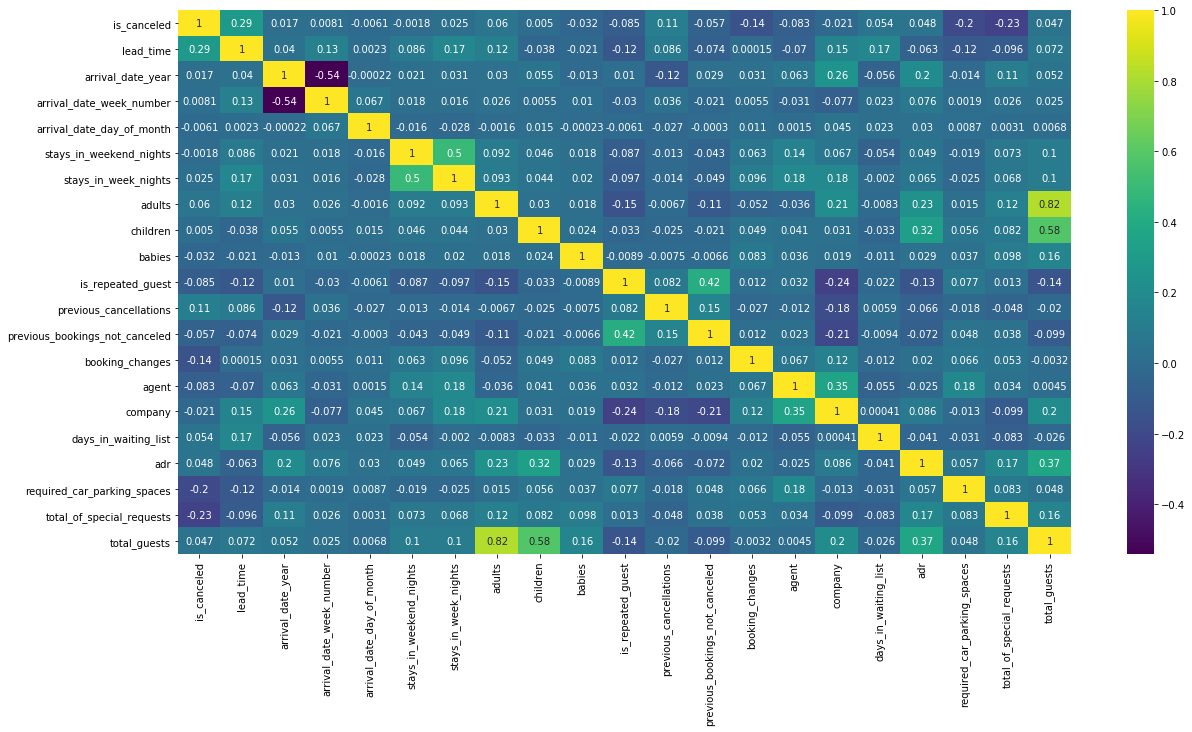

In [26]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

The leadtime attribute had the strongest linear correlation with cancellation.

Let's look at the correlation values in a bar graph.

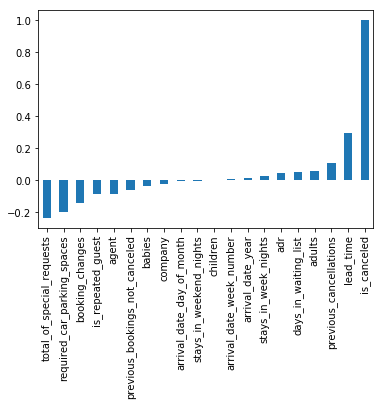

In [27]:
df.corr()['is_canceled'][:-1].sort_values().plot(kind='bar')

We can more clearly see that both lead_time and total_of_special_requests had the strongest linear correlations with is_canceled target variable.

# 3. Dimensionality reduction : PCA & TSNE

## 3.1 Categorical features only

Now I want to run PCA analysis on categorical features to see if we can really reduce our dataset dimensionality. For PCA to run effectively, let's convert categorical features to numerical ones using Scikit-learn. This requires running integer encoding first follwed by OneHotEncoding.

In [28]:
# Separate features and predicted value
X_cat = df_cat.drop("is_canceled", axis=1)
y_cat = df_cat["is_canceled"].eq('yes').mul(1)

Quickly looking at X_cat..

In [29]:
X_cat.head()

reservation_status_date market_segment country deposit_type customer_type  \
0              2015-07-01         Direct     PRT   No Deposit     Transient   
1              2015-07-01         Direct     PRT   No Deposit     Transient   
2              2015-07-02         Direct     GBR   No Deposit     Transient   
3              2015-07-02      Corporate     GBR   No Deposit     Transient   
4              2015-07-03      Online TA     GBR   No Deposit     Transient   

  reserved_room_type assigned_room_type distribution_channel meal  \
0                  C                  C               Direct   BB   
1                  C                  C               Direct   BB   
2                  A                  C               Direct   BB   
3                  A                  A            Corporate   BB   
4                  A                  A                TA/TO   BB   

  arrival_date_month         hotel  
0               July  Resort Hotel  
1               July  Resort Hotel  
2               July  Resort Hotel  
3               July  Resort Hotel  
4               July  Resort Hotel

We saw during our data exploration that the "country" feature had some missing values. Let's take care of this before moving along.

In [30]:
X_cat['country'].fillna("No Country", inplace = True)

Running labelencoder and onehotencoder to convert to numerical features.

In [31]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def labelencode(df):
    le = LabelEncoder()
    return df.apply(le.fit_transform)

def onehotencode(df):
    onehot = OneHotEncoder()
    return onehot.fit_transform(df).toarray()

X_2 = labelencode(X_cat)
onehotlabels = onehotencode(X_2)

Let's take a look at X_2 to see how the labels have been converted to numerical digits instead.

In [32]:
X_2.head().transpose()

0    1    2    3    4
reservation_status_date  121  121  122  122  123
market_segment             3    3    3    2    6
country                  136  136   59   59   59
deposit_type               0    0    0    0    0
customer_type              2    2    2    2    2
reserved_room_type         2    2    0    0    0
assigned_room_type         2    2    2    0    0
distribution_channel       1    1    1    0    3
meal                       0    0    0    0    0
arrival_date_month         5    5    5    5    5
hotel                      1    1    1    1    1

Let's first choose 3 principal components to try PCA.

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

# Perform PCA on the one-hot encoded labels
X_pca = pca.fit_transform(onehotlabels)

Now we can find the explained_variance_ratio, which shows the amount of information or variance each principal component holds after projecting the data to a lower dimensional subspace.

In [34]:
ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

[0.44257446 0.32937114 0.2280544 ]


This means that the principal component 1 holds 44.2% of the information while the principal component 2 holds only 32.9% of the information. Summing them up, we will have ~77% of information.

Let's run PCA analysis when the number of principal components is equal to the number of all attributes in the categorical feature dataset.

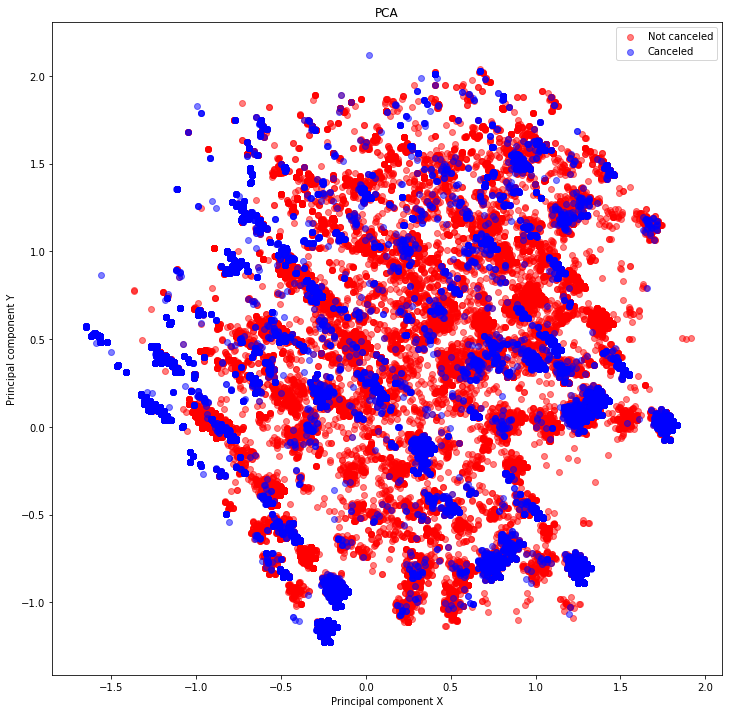

In [35]:
pca = PCA(n_components=len(df_cat.columns))

# Perform PCA on the one-hot encoded labels
X_pca = pca.fit_transform(onehotlabels)

# Rebuild it in its original dimension
X_pca_reconst = pca.inverse_transform(X_pca)

#plotting

plt.figure(figsize=(12,12))

plt.scatter(X_pca[y_cat==0, 0], X_pca[y_cat==0, 1], color='red', alpha=0.5,label='Not canceled')
plt.scatter(X_pca[y_cat==1, 0], X_pca[y_cat==1, 1], color='blue', alpha=0.5,label='Canceled')

plt.title("PCA")
plt.ylabel('Principal component Y')
plt.xlabel('Principal component X')
plt.legend()
plt.show()

The ideal pattern would be distinct clusters where the clusters are not overlapping with each other a lot.

Then, how many principal components we would have needed to represent the whole dataset? Let's plot the cumuluative explained variances as a function of principal components, when the # of principal components is set equal to the number of total categorical features we have in the dataframe.

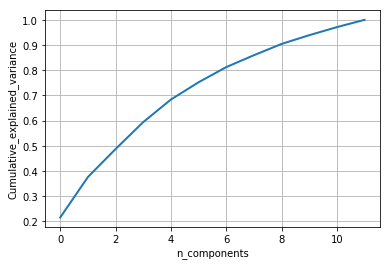

In [36]:
pca = PCA(n_components=len(df_cat.columns))
X_pca = pca.fit_transform(onehotlabels)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

We can see that we need about 8 components to represent 90% of the dataset.

There is TSNE analysis that is known to improve distinction although it is quite resource-heavy. This is why I installed CUDF and CUML at the beginning of this kernel to utilize GPU.

This medium post (https://towardsdatascience.com/dimensionality-reduction-toolbox-in-python-9a18995927cd) explains pretty well about TSNE (and other dimension reduction features too): T-SNE reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space.

To make sure we don’t burden our machine in terms of memory and power/time we will only use the 20,000 samples to run the algorithm.

In [37]:
import cudf, cuml
from cuml.manifold import TSNE
import time

time_start = time.time()

tsne = TSNE(n_components=2,verbose=1, learning_rate=300,perplexity = 50,early_exaggeration = 24,init = 'random',  random_state=2019)

n = 20000  # for 20000 random indices
index = np.random.choice(onehotlabels.shape[0], n, replace=False)  

X_tsne=tsne.fit_transform(onehotlabels[index])
y_tsne=y_cat[index]

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 78, learning_rate = 6666.666666666666, exaggeration = 24.0
t-SNE done! Time elapsed: 5.91101598739624 seconds


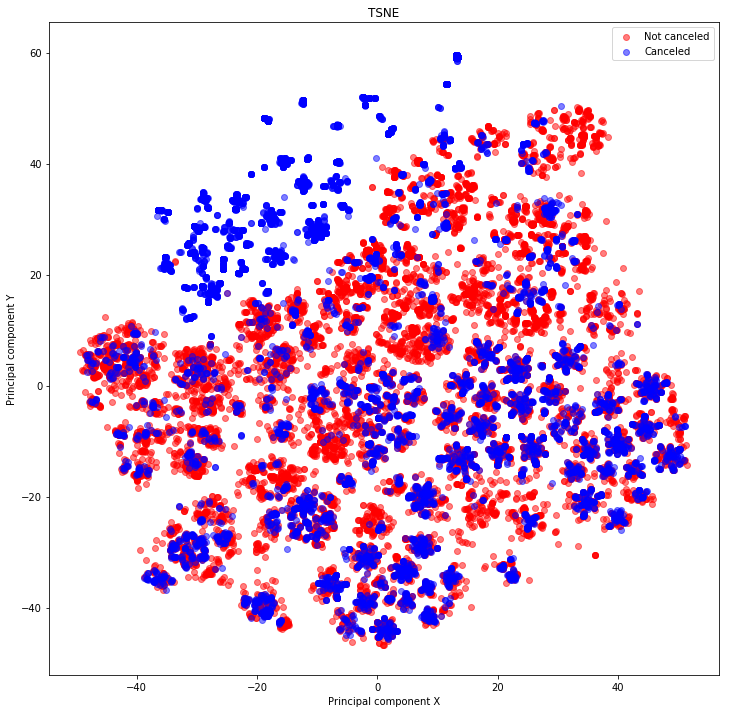

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))

plt.scatter(X_tsne[y_tsne==0, 0], X_tsne[y_tsne==0, 1], color='red', alpha=0.5,label='Not canceled')
plt.scatter(X_tsne[y_tsne==1, 0], X_tsne[y_tsne==1, 1], color='blue', alpha=0.5,label='Canceled')
plt.title("TSNE")
plt.ylabel('Principal component Y')
plt.xlabel('Principal component X')
plt.legend()
plt.show()

The overlapping between the two clusters is smaller in TSNE than in PCA but still not super distinct unfortunately. This could be attributed to the sample size, learning rate or perplexity we chose.

## 3.2 What about numerical features?

Let's look at the numerical features the same way we looked at the categorical features for the PCA analysis.

First, I will choose the numerical features only and go through standardization.

In [39]:
#getting the numerical feature columns one more time
cols = df.columns
num_cols = df._get_numeric_data().columns

#selecting numerical features
df_num=df[num_cols].drop('is_canceled',axis=1)

#selecting target ('is_canceled' column)
y_num=y_cat

In [40]:
df_num.columns

Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'total_guests'],
      dtype='object')

For the missing numerical data, let's Panda's fillna feature. We will fill in with the median values.

In [41]:
df_num=df_num.fillna(df_num.median())

Running standardization on this dataframe using StandardScaler and replacing the orignial dataframe with the standardized one.

In [42]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
df_num_standard = StandardScaler().fit_transform(df_num.values)

#replacing the X_num dataframe with the standardized dataframe
df_num[:] = df_num_standard

In [43]:
df_num.head().transpose()

0         1         2         3  \
lead_time                       2.227051  5.923385 -0.907814 -0.851667   
arrival_date_year              -1.634768 -1.634768 -1.634768 -1.634768   
arrival_date_week_number       -0.012141 -0.012141 -0.012141 -0.012141   
arrival_date_day_of_month      -1.685297 -1.685297 -1.685297 -1.685297   
stays_in_weekend_nights        -0.928890 -0.928890 -0.928890 -0.928890   
stays_in_week_nights           -1.310240 -1.310240 -0.786207 -0.786207   
adults                          0.247897  0.247897 -1.478447 -1.478447   
children                       -0.260659 -0.260659 -0.260659 -0.260659   
babies                         -0.081579 -0.081579 -0.081579 -0.081579   
is_repeated_guest              -0.181560 -0.181560 -0.181560 -0.181560   
previous_cancellations         -0.103180 -0.103180 -0.103180 -0.103180   
previous_bookings_not_canceled -0.091555 -0.091555 -0.091555 -0.091555   
booking_changes                 4.260101  5.793131 -0.338990 -0.338990   
agent                          -0.592464 -0.592464 -0.592464  2.145860   
company                        -0.018555 -0.018555 -0.018555 -0.018555   
days_in_waiting_list           -0.131924 -0.131924 -0.131924 -0.131924   
adr                            -2.015038 -2.015038 -0.530935 -0.530935   
required_car_parking_spaces    -0.254873 -0.254873 -0.254873 -0.254873   
total_of_special_requests      -0.720694 -0.720694 -0.720694 -0.720694   
total_guests                    0.043979  0.043979 -1.340324 -1.340324   

                                       4  
lead_time                      -0.842309  
arrival_date_year              -1.634768  
arrival_date_week_number       -0.012141  
arrival_date_day_of_month      -1.685297  
stays_in_weekend_nights        -0.928890  
stays_in_week_nights           -0.262174  
adults                          0.247897  
children                       -0.260659  
babies                         -0.081579  
is_repeated_guest              -0.181560  
previous_cancellations         -0.103180  
previous_bookings_not_canceled -0.091555  
booking_changes                -0.338990  
agent                           1.541540  
company                        -0.018555  
days_in_waiting_list           -0.131924  
adr                            -0.075810  
required_car_parking_spaces    -0.254873  
total_of_special_requests       0.540666  
total_guests                    0.043979

Let's run PCA on this dataset.

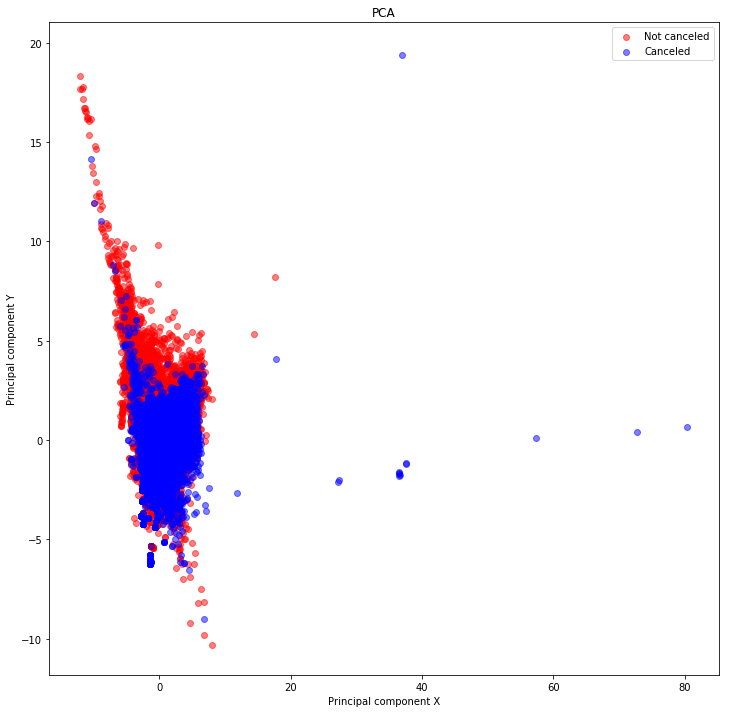

In [44]:
pca = PCA(n_components=len(df_num.columns))

# Perform PCA on the one-hot encoded labels
df_pca_num = pca.fit_transform(df_num)

#plotting

plt.figure(figsize=(12,12))

plt.scatter(df_pca_num[y_num==0, 0], df_pca_num[y_num==0, 1], color='red', alpha=0.5,label='Not canceled')
plt.scatter(df_pca_num[y_num==1, 0], df_pca_num[y_num==1, 1], color='blue', alpha=0.5,label='Canceled')

plt.title("PCA")
plt.ylabel('Principal component Y')
plt.xlabel('Principal component X')
plt.legend()
plt.show()

Still the two clusters are overlapping with each other a lot.

What about TSNE analysis on the numerical features?

In [45]:
import cudf, cuml
from cuml.manifold import TSNE
import time

time_start = time.time()

tsne = TSNE(n_components=2,verbose=1, learning_rate=300,perplexity = 50,early_exaggeration = 24,init = 'random',  random_state=2019)

n = 20000  # for 2 random indices
index = np.random.choice(df_num_standard.shape[0], n, replace=False)  

X_tsne=tsne.fit_transform(df_num_standard[index])
y_tsne=y_num[index]

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 78, learning_rate = 6666.666666666666, exaggeration = 24.0
t-SNE done! Time elapsed: 2.6632299423217773 seconds


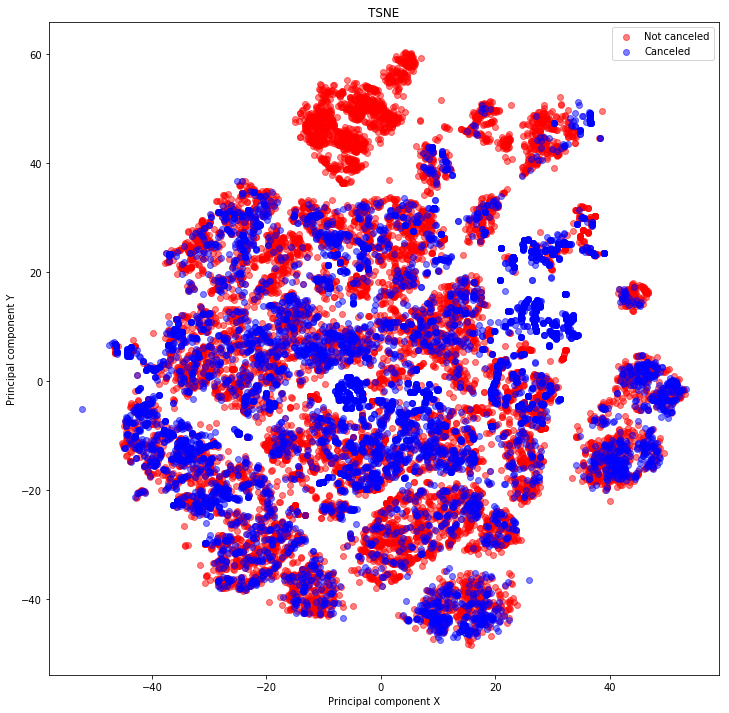

In [46]:
plt.figure(figsize=(12,12))

plt.scatter(X_tsne[y_tsne==0, 0], X_tsne[y_tsne==0, 1], color='red', alpha=0.5,label='Not canceled')
plt.scatter(X_tsne[y_tsne==1, 0], X_tsne[y_tsne==1, 1], color='blue', alpha=0.5,label='Canceled')
plt.title("TSNE")
plt.ylabel('Principal component Y')
plt.xlabel('Principal component X')
plt.legend()
plt.show()

Again, the two are overlapping with each other a lot so I am not entirely sure if our classification will work accurately. Let's give it a shot with our ANN models anyway for my practice :)

# 4. Running ANN classification algorithm

Despite of not so ideal results we got from PCA and TSNE analysis on both categorical and numerical features, let's try to predict cancellation using the ANN claffisication algorithm for practice :)

Let's first concatanate our numerically converted categorical features (those that went through onehotencoder) and standardized numerical features toegether. Since we will need arrays for our ANN, we will concatanate the arrays, not the dataframe.

In [47]:
#concatenating numerically converted categorical and numerical feature arrays
X_arr=np.concatenate((onehotlabels, df_num_standard), axis=1)
y_arr = df['is_canceled'].values

Splitting the data into train and test sets

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_arr,y_arr,test_size=0.25,random_state=2019)

## 4.1 Model creation : layer setup + compiling

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

Checking the train feature shape to see if the splitting was done as intended

In [50]:
X_train.shape

(89542, 1185)

Let's create layers to run our ANN! I am going to use "relu" as my activation function, "binary_crossentropy" as a loss function and "adam" as an optimizer during compiling.

In [51]:
model = Sequential()

#adding dropout layers for improved learning
model.add(Dense(units=30,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=20,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=10,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

# For a binary classification problem
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

## 4.2 Training the model

In [52]:
#Putting early_stop in to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

model.fit(x=X_train, 
          y=y_train, 
          epochs=100,
          validation_data=(X_test, y_test), verbose=1,callbacks=[early_stop]
          )

Train on 89542 samples, validate on 29848 samples
Epoch 1/100
89542/89542 [==============================] - 14s 160us/sample - loss: 0.4467 - accuracy: 0.7848 - val_loss: 0.3174 - val_accuracy: 0.8591
Epoch 2/100
89542/89542 [==============================] - 13s 145us/sample - loss: 0.3615 - accuracy: 0.8327 - val_loss: 0.2926 - val_accuracy: 0.8733
Epoch 3/100
89542/89542 [==============================] - 13s 147us/sample - loss: 0.3356 - accuracy: 0.8478 - val_loss: 0.2669 - val_accuracy: 0.8870
Epoch 4/100
89542/89542 [==============================] - 14s 153us/sample - loss: 0.3146 - accuracy: 0.8569 - val_loss: 0.2587 - val_accuracy: 0.8878
Epoch 5/100
89542/89542 [==============================] - 13s 142us/sample - loss: 0.3027 - accuracy: 0.8643 - val_loss: 0.2426 - val_accuracy: 0.9002
Epoch 6/100
89542/89542 [==============================] - 13s 144us/sample - loss: 0.2905 - accuracy: 0.8678 - val_loss: 0.2329 - val_accuracy: 0.9071
Epoch 7/100
89542/89542 [=============

Let's plot our model history (accuracy and loss) to see how our epochs worked.

In [53]:
model_loss = pd.DataFrame(model.history.history)

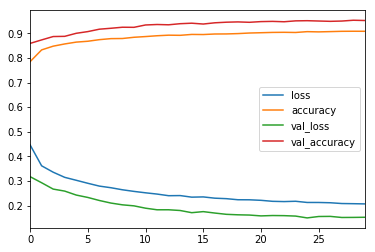

In [54]:
model_loss.plot()

Alright. Looks like we really did not overfit based on the trend of the validation loss (didn't swing back up)

## 4.3 Make predictions & Model evaluation

Creating predctions.

In [55]:
predictions = model.predict_classes(X_test)

Let's take a look at the confusion matrix to evalute our classificatio work.

In [56]:
from sklearn.metrics import classification_report,confusion_matrix

In [57]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     18732
           1       0.97      0.90      0.93     11116

    accuracy                           0.95     29848
   macro avg       0.96      0.94      0.95     29848
weighted avg       0.95      0.95      0.95     29848



Our f1-score is not bad at all :)

In [58]:
print(confusion_matrix(y_test,predictions))

[[18428   304]
 [ 1123  9993]]


From this confusion matrix on test set, we can see that both false negative and false positive cases are fairly small compared to the size of the whole test dataset.

As the additional means of verification, let's look at the very first prediction.

In [59]:
predictions[0]

array([0], dtype=int32)

We can see that it expected "0" which means no cancellation.

Examining the test label shows that this classification is correct:

In [60]:
y_test[0]

0

What about another prediction? Like.. 12345th prediction? Let's compare the predicted value and actual test value.

In [61]:
if predictions[12345] == y_test[12345]:
    print("Prediction and test value match")
else:
    print("Prediction and test value do NOT match")

Prediction and test value match


Nice! Even though the clustering did not look ideal in our PCA and TSNE analysis, deep learning was able to figure it out!
We can use this trained model to predict whether a hotel room will be canceled or not given various input features :)